# Clustering Solution Generator
### $Time$ $Series$ $4th$ $Test$

$Vasco$ $Mergulhão$ $-$ $April$ $2023$

### Version 1:
This script loads a model and outputs a CSV ready to be analysed on the Dashboard

In [1]:
import os

In [2]:
on_gradient = False
directory = os.getcwd()
if directory == '/notebooks':
    on_gradient = True

In [3]:
if on_gradient == False:
    os.environ["OMP_NUM_THREADS"] = "4"
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

In [4]:
if on_gradient == False:
    import plotly.express as px
    import plotly.graph_objects as go
    import umap
    from umap.umap_ import nearest_neighbors    

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
from sklearn.cluster import KMeans
import Transform
import tensorflow as tf
from tensorflow import keras
from keras import models
import wandb
from wandb.keras import WandbCallback

C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Set Random Seeds
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

---
# Script Variables

In [6]:
dataset_name = 'Kenya_90k_Set_1_w90_pW'
Model_Name = 'LSTM_AE' # Options: FC_N2D, LSTM_AE, CNN_AE, CNN_ConvEmb
solution_name = 'efficient-sweep-2:v49'
max_num_clusters = 25

### Other dependabels

In [7]:
# Uses name to navigate folders
if on_gradient == False:
    dataset_folder = "_".join(dataset_name.split('_')[:-2]) 
    dataset_location = f'../Data_Storage_Processing/Data/{dataset_folder}/{dataset_name}.csv'
else:
    gradient_mountedfiles = ! ls /datasets/s3_bucket #!ls /datasets/kenya-90k-set-1-w90
    print(f'Datasets mounted: {gradient_mountedfiles}')
    dataset_location = f'/datasets/s3_bucket/{dataset_name}.csv'

In [8]:
window_cols, window_len = Transform.retrive_window_col_names(dataset_name)
# Project Name
scaler_dict = {'Orig':'OriginalScale',
               'pW':'pWindow',
               'G':'Gobal'}
dataset_name_base = "_".join(dataset_name.split('_')[:-1])
scaler_used = dataset_name.split('_')[-1]

Project_Name = f'DeepClust--{dataset_name_base}--{scaler_dict[scaler_used]}'

---
# Data Imports

In [9]:
Data = pd.read_csv(dataset_location)

In [10]:
Data = Data[:1000]

In [11]:
data = Data[window_cols].values

In [12]:
Data.head()

,short_ID,window_ID,window_start_date,d1,d2,d3,d4,d5,d6,d7,...,d81,d82,d83,d84,d85,d86,d87,d88,d89,d90
0,127,0,2018-01-20,0.543805,0.503693,0.463580,0.423467,0.383355,0.343242,0.303129,...,0.906409,0.904819,0.864707,0.786444,0.784481,0.706456,0.666459,0.626384,0.586360,0.583918
1,127,1,2018-04-20,0.525359,0.522565,0.480950,0.439334,0.397718,0.317612,0.314487,...,1.019053,0.977438,0.935822,0.894206,0.852591,0.810975,0.769359,0.727744,0.686128,0.644512
2,127,2,2018-07-19,0.651208,0.606258,0.561307,0.516357,0.471407,0.426456,0.381506,...,1.013146,0.968196,0.923246,0.878295,0.833345,0.788395,0.743444,0.698494,0.653543,0.608593
3,127,3,2018-10-17,0.594276,0.546883,0.499489,0.452096,0.404703,0.357309,0.309916,...,0.499489,0.452096,0.404703,0.357309,0.309916,0.262522,0.215129,0.167736,0.120342,0.072949
4,127,4,2019-01-15,0.953922,0.853922,0.753922,0.653922,0.553922,0.453922,0.353922,...,0.453922,0.353922,0.253922,0.153922,0.753922,0.653922,0.553922,0.453922,0.353922,2.000000


## Reshaping Data

In [13]:
if Model_Name == 'FC_N2D':
    predict_data =  Data[window_cols].to_numpy()
else:
    predict_data =  Data[window_cols].to_numpy().reshape(-1, window_len, 1)

In [14]:
predict_data.shape

(1000, 90, 1)

---
# Problematic Libraries

In [15]:
if on_gradient == True:
    ! pip install plotly
    ! pip install umap-learn
    
    import plotly.express as px
    import plotly.graph_objects as go
    import umap
    from umap.umap_ import nearest_neighbors    

---
---
# 2D UMAP

In [16]:
start_knn_time = time.time()
knn_orig_precomp = nearest_neighbors(data,
                              n_neighbors=30,
                              metric="euclidean",
                              metric_kwds=None,
                              angular=False,
                              random_state=42)

print(f'Precomp Time: {np.round(time.time() - start_knn_time,2)}[s]')  

Precomp Time: 16.73[s]


In [17]:
start_time = time.time()
umap_viz_model = umap.UMAP(random_state=42,
                           n_neighbors=15,
                           min_dist= 0.1,
                           n_components = 2,
                           precomputed_knn= knn_orig_precomp,
                          ).fit(data)

v_2D_umap = umap_viz_model.transform(data)

print(f'Total Time: {np.round(time.time() - start_time,2)}[s]')  


C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\umap\umap_.py:1956: UserWarning: precomputed_knn is meant for large datasets. Since your data is small, precomputed_knn will be ignored and the k-nn will be computed normally.
  warn(


Total Time: 11.8[s]


---
---
# Loading Model

In [18]:
run = wandb.init()
model_artifact = run.use_artifact(f'vasco-phd/{Project_Name}/model-{solution_name}', type='model')
model_dir = model_artifact.download()
# local_model_dir = 'C:/Users/ucesvpm/OneDrive - University College London/PhD Project/Data Analytics/Time Series Clustering/Second Test/wandb/run-20221213_173041-jc918077'
loaded_autoencoder = tf.keras.models.load_model(model_dir)
run.finish()

wandb: Currently logged in as: vasco-mergulhao (vasco-phd). Use `wandb login --relogin` to force relogin


wandb:   4 of 4 files downloaded.  


In [19]:
loaded_autoencoder.summary()

Model: "LSTM_AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 90, 1)]           0         
                                                                 
 Encoder (LSTM)              (None, 90, 100)           40800     
                                                                 
 Lantent_Space (LSTM)        (None, 25)                12600     
                                                                 
 Reshape_Embeding (RepeatVec  (None, 90, 25)           0         
 tor)                                                            
                                                                 
 Decoder_1 (LSTM)            (None, 90, 25)            5100      
                                                                 
 Decoder_2 (LSTM)            (None, 90, 100)           50400     
                                                           

In [20]:
# bottleneck model
encoder_output = loaded_autoencoder.get_layer('Lantent_Space').output
encoder = models.Model(inputs = loaded_autoencoder.input, outputs = encoder_output, name = f'{Model_Name}_encoder')
encoder.summary()

Model: "LSTM_AE_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 90, 1)]           0         
                                                                 
 Encoder (LSTM)              (None, 90, 100)           40800     
                                                                 
 Lantent_Space (LSTM)        (None, 25)                12600     
                                                                 
Total params: 53,400
Trainable params: 53,400
Non-trainable params: 0
_________________________________________________________________


---
# Saving Encoder

In [21]:
solution_fileName = solution_name.replace(":", "-" ).replace("-", "_" )
Encoder_Name = f'{Model_Name}-{solution_fileName}'
# encoder.save(f'SavedModels/{Encoder_Name}')

---
#  Reconstruction Error

In [22]:
# Calculates the RModelontruction Profiles (Predictions)
reconstruct_data = loaded_autoencoder.predict(predict_data)

32/32 [==============================] - 3s 26ms/step


In [23]:
# Saves the Reconstructect windows
df_reconstruct = Data[['short_ID', 'window_ID']].copy(deep=True)
if Model_Name == 'FC_N2D':
    df_reconstruct[window_cols] = reconstruct_data
else:
    df_reconstruct[window_cols] = reconstruct_data.reshape(-1, window_len)

In [24]:
# Calculating MSE per window
MSE = tf.keras.losses.MeanSquaredError(reduction='none')
if Model_Name == 'FC_N2D':
    MSE_values = MSE(predict_data, reconstruct_data).numpy()
else:
    MSE_values = MSE(predict_data.reshape(-1, window_len), reconstruct_data.reshape(-1, window_len)).numpy()
#Adding to reconstructed dataframe
df_reconstruct.insert(loc=2, column='MSE', value=MSE_values)

In [25]:
df_reconstruct.head()

,short_ID,window_ID,MSE,d1,d2,d3,d4,d5,d6,d7,...,d81,d82,d83,d84,d85,d86,d87,d88,d89,d90
0,127,0,0.036224,0.551866,0.511525,0.418921,0.393570,0.376943,0.354484,0.342850,...,0.918718,0.906462,0.890662,0.858993,0.806989,0.740205,0.668449,0.601423,0.551958,0.541089
1,127,1,0.001781,0.511137,0.535627,0.456171,0.430780,0.399154,0.356051,0.327404,...,1.020759,0.995790,0.969248,0.935301,0.888822,0.829687,0.764942,0.704779,0.660446,0.643842
2,127,2,0.008751,0.540324,0.648341,0.572467,0.494882,0.453017,0.394184,0.348231,...,0.935303,0.903605,0.875646,0.850747,0.823421,0.788953,0.749272,0.711617,0.685288,0.679950
3,127,3,0.003819,0.503273,0.541258,0.460892,0.437429,0.392647,0.366842,0.359645,...,0.443012,0.411199,0.390286,0.376721,0.359625,0.327530,0.277821,0.214182,0.147162,0.123559
4,127,4,0.057101,1.141542,0.830329,0.652757,0.551421,0.494866,0.487153,0.502427,...,0.576964,0.515441,0.453450,0.377552,0.284933,0.226393,0.501658,1.006430,0.971729,0.888564


In [26]:
# Calculating Latent Space Projection
encoded_data = encoder.predict(predict_data)

32/32 [==============================] - 1s 14ms/step


In [27]:
# encoded_data = encoded_data.numpy()
# df_encoded = pd.DataFrame(encoded_data)

In [28]:
#Adds UMAP viz Dims to Dataframes
df_reconstruct.insert(loc=2, column='UMAP_V2', value=v_2D_umap[:, 1])
df_reconstruct.insert(loc=2, column='UMAP_V1', value=v_2D_umap[:, 0])

---
---
# Clustering Solutions

In [29]:
# Creates DF for Clustering Solutions
df_sols  = Data.copy(deep=True)
df_sols.drop(window_cols, axis=1, inplace=True)

In [30]:
#Adds UMAP viz Dims to Dataframes
df_sols['UMAP_V1'] = v_2D_umap[:, 0]
df_sols['UMAP_V2'] = v_2D_umap[:, 1]

### kMeans

In [ ]:
if Model_Name == 'CNN_ConvEmb':
    latent_size = loaded_autoencoder.get_layer('Latent_Space').output_shape[-1]
    encoded_data = encoded_data.reshape(-1, latent_size)
encoded_data.shape

In [31]:
print('Clustering on Encoded Space\n')
start_total_time = time.time()
clust_sol_cols = []
for k in range(2, max_num_clusters + 1):
    # UMAPing to macthed k=dims with cluster friendly settings
    start_ind_sol_time = time.time()
    print(f'Processing kMeans for k={k}')
    partition = KMeans(n_clusters=k, random_state=42).fit(encoded_data)
    sol_name = f'kMeans_k{k}'
    clust_sol_cols.append(sol_name)
    df_sols[sol_name] = partition.labels_ + 1
    print(f'Time: {np.round(time.time() - start_ind_sol_time,2)}[s]\n')  

print(f'Total Time: {np.round(time.time() - start_total_time,2)}[s]')  

Clustering on Encoded Space

Processing kMeans for k=2
Time: 0.3[s]

Processing kMeans for k=3
Time: 0.23[s]

Processing kMeans for k=4
Time: 0.24[s]

Processing kMeans for k=5
Time: 0.24[s]

Processing kMeans for k=6
Time: 0.25[s]

Processing kMeans for k=7
Time: 0.27[s]

Processing kMeans for k=8
Time: 0.29[s]

Processing kMeans for k=9
Time: 0.3[s]

Processing kMeans for k=10
Time: 0.52[s]

Processing kMeans for k=11
Time: 0.48[s]

Processing kMeans for k=12
Time: 0.67[s]

Processing kMeans for k=13
Time: 0.42[s]

Processing kMeans for k=14
Time: 0.62[s]

Processing kMeans for k=15
Time: 0.52[s]

Processing kMeans for k=16
Time: 0.56[s]

Processing kMeans for k=17
Time: 0.69[s]

Processing kMeans for k=18
Time: 0.62[s]

Processing kMeans for k=19
Time: 0.59[s]

Processing kMeans for k=20
Time: 0.75[s]

Processing kMeans for k=21
Time: 0.66[s]

Processing kMeans for k=22
Time: 0.62[s]

Processing kMeans for k=23
Time: 0.59[s]

Processing kMeans for k=24
Time: 0.88[s]

Processing kMea

In [32]:
df_sols.head()

,short_ID,window_ID,window_start_date,UMAP_V1,UMAP_V2,kMeans_k2,kMeans_k3,kMeans_k4,kMeans_k5,kMeans_k6,...,kMeans_k16,kMeans_k17,kMeans_k18,kMeans_k19,kMeans_k20,kMeans_k21,kMeans_k22,kMeans_k23,kMeans_k24,kMeans_k25
0,127,0,2018-01-20,14.730165,14.922711,1,3,1,4,6,...,2,1,10,6,9,11,21,6,15,11
1,127,1,2018-04-20,14.456367,15.064330,1,3,1,4,6,...,2,1,10,6,9,11,21,6,15,11
2,127,2,2018-07-19,14.490791,14.844275,1,3,1,4,6,...,9,13,13,10,1,15,14,17,12,17
3,127,3,2018-10-17,13.377369,15.922905,1,3,1,4,6,...,2,10,1,15,14,5,21,18,15,21
4,127,4,2019-01-15,14.862516,16.851736,1,3,1,4,6,...,9,13,16,1,10,15,14,17,10,15


### KUMAP

In [33]:
start_knn_time = time.time()
knn_encoded_precomp = nearest_neighbors(encoded_data,
                              n_neighbors=30,
                              metric="euclidean",
                              metric_kwds=None,
                              angular=False,
                              random_state=42)

print(f'Precomp Time: {np.round(time.time() - start_knn_time,2)}[s]')  

Precomp Time: 1.27[s]


In [34]:
print("Clustering on UMAP'ed Encoded Space\n")
start_total_time = time.time()
for k in range(2, max_num_clusters + 1):
    print(f'Processing for k={k}')
    # UMAPing to macthed k=dims with cluster friendly settings
    start_ind_UMAP_time = time.time()
    print(f'Working UMAP')
    # Settings from https://umap-learn.readthedocs.io/en/latest/clustering.html
    # General idea is larger n_neighbors to capture wider relationships, and smaller min_dist to keep points closer (better for density alg)   
    umap_clust_model = umap.UMAP(random_state=42,
                           n_neighbors=30,
                           min_dist= 0,
                           n_components = k,
                           precomputed_knn= knn_encoded_precomp,
                          ).fit(encoded_data)
    clust_umap = umap_clust_model.transform(encoded_data)
    
    print(f'Time: {np.round(time.time() - start_ind_UMAP_time,2)}[s]')
    
    start_ind_sol_time = time.time()
    print(f'Working kMeans')
    partition = KMeans(n_clusters=k, random_state=42).fit(clust_umap)
    sol_name = f'KUMAP_k{k}'
    clust_sol_cols.append(sol_name)
    df_sols[sol_name] = partition.labels_ + 1
    print(f'Time: {np.round(time.time() - start_ind_sol_time,2)}[s]\n')  

print(f'Total Time: {np.round(time.time() - start_total_time,2)}[s]')        

Clustering on UMAP'ed Encoded Space

Processing for k=2
Working UMAP


C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\umap\umap_.py:1956: UserWarning: precomputed_knn is meant for large datasets. Since your data is small, precomputed_knn will be ignored and the k-nn will be computed normally.
  warn(


Time: 6.86[s]
Working kMeans
Time: 0.28[s]

Processing for k=3
Working UMAP


C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\umap\umap_.py:1956: UserWarning: precomputed_knn is meant for large datasets. Since your data is small, precomputed_knn will be ignored and the k-nn will be computed normally.
  warn(


Time: 5.87[s]
Working kMeans
Time: 0.23[s]

Processing for k=4
Working UMAP


C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\umap\umap_.py:1956: UserWarning: precomputed_knn is meant for large datasets. Since your data is small, precomputed_knn will be ignored and the k-nn will be computed normally.
  warn(


Time: 5.86[s]
Working kMeans
Time: 0.3[s]

Processing for k=5
Working UMAP


C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\umap\umap_.py:1956: UserWarning: precomputed_knn is meant for large datasets. Since your data is small, precomputed_knn will be ignored and the k-nn will be computed normally.
  warn(


Time: 6.79[s]
Working kMeans
Time: 0.33[s]

Processing for k=6
Working UMAP


C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\umap\umap_.py:1956: UserWarning: precomputed_knn is meant for large datasets. Since your data is small, precomputed_knn will be ignored and the k-nn will be computed normally.
  warn(


Time: 6.59[s]
Working kMeans
Time: 0.27[s]

Processing for k=7
Working UMAP


C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\umap\umap_.py:1956: UserWarning: precomputed_knn is meant for large datasets. Since your data is small, precomputed_knn will be ignored and the k-nn will be computed normally.
  warn(


Time: 5.84[s]
Working kMeans
Time: 0.26[s]

Processing for k=8
Working UMAP


C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\umap\umap_.py:1956: UserWarning: precomputed_knn is meant for large datasets. Since your data is small, precomputed_knn will be ignored and the k-nn will be computed normally.
  warn(


Time: 6.72[s]
Working kMeans
Time: 0.24[s]

Processing for k=9
Working UMAP


C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\umap\umap_.py:1956: UserWarning: precomputed_knn is meant for large datasets. Since your data is small, precomputed_knn will be ignored and the k-nn will be computed normally.
  warn(


Time: 6.46[s]
Working kMeans
Time: 0.28[s]

Processing for k=10
Working UMAP


C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\umap\umap_.py:1956: UserWarning: precomputed_knn is meant for large datasets. Since your data is small, precomputed_knn will be ignored and the k-nn will be computed normally.
  warn(


Time: 6.93[s]
Working kMeans
Time: 0.3[s]

Processing for k=11
Working UMAP


C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\umap\umap_.py:1956: UserWarning: precomputed_knn is meant for large datasets. Since your data is small, precomputed_knn will be ignored and the k-nn will be computed normally.
  warn(


Time: 6.8[s]
Working kMeans
Time: 0.33[s]

Processing for k=12
Working UMAP


C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\umap\umap_.py:1956: UserWarning: precomputed_knn is meant for large datasets. Since your data is small, precomputed_knn will be ignored and the k-nn will be computed normally.
  warn(


Time: 7.65[s]
Working kMeans
Time: 0.28[s]

Processing for k=13
Working UMAP


C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\umap\umap_.py:1956: UserWarning: precomputed_knn is meant for large datasets. Since your data is small, precomputed_knn will be ignored and the k-nn will be computed normally.
  warn(


Time: 7.09[s]
Working kMeans
Time: 0.32[s]

Processing for k=14
Working UMAP


C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\umap\umap_.py:1956: UserWarning: precomputed_knn is meant for large datasets. Since your data is small, precomputed_knn will be ignored and the k-nn will be computed normally.
  warn(


Time: 8.06[s]
Working kMeans
Time: 0.3[s]

Processing for k=15
Working UMAP


C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\umap\umap_.py:1956: UserWarning: precomputed_knn is meant for large datasets. Since your data is small, precomputed_knn will be ignored and the k-nn will be computed normally.
  warn(


Time: 7.66[s]
Working kMeans
Time: 0.31[s]

Processing for k=16
Working UMAP


C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\umap\umap_.py:1956: UserWarning: precomputed_knn is meant for large datasets. Since your data is small, precomputed_knn will be ignored and the k-nn will be computed normally.
  warn(


Time: 8.3[s]
Working kMeans
Time: 0.31[s]

Processing for k=17
Working UMAP


C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\umap\umap_.py:1956: UserWarning: precomputed_knn is meant for large datasets. Since your data is small, precomputed_knn will be ignored and the k-nn will be computed normally.
  warn(


Time: 9.47[s]
Working kMeans
Time: 0.26[s]

Processing for k=18
Working UMAP


C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\umap\umap_.py:1956: UserWarning: precomputed_knn is meant for large datasets. Since your data is small, precomputed_knn will be ignored and the k-nn will be computed normally.
  warn(


Time: 8.82[s]
Working kMeans
Time: 0.28[s]

Processing for k=19
Working UMAP


C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\umap\umap_.py:1956: UserWarning: precomputed_knn is meant for large datasets. Since your data is small, precomputed_knn will be ignored and the k-nn will be computed normally.
  warn(


Time: 8.22[s]
Working kMeans
Time: 0.31[s]

Processing for k=20
Working UMAP


C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\umap\umap_.py:1956: UserWarning: precomputed_knn is meant for large datasets. Since your data is small, precomputed_knn will be ignored and the k-nn will be computed normally.
  warn(


Time: 8.72[s]
Working kMeans
Time: 0.28[s]

Processing for k=21
Working UMAP


C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\umap\umap_.py:1956: UserWarning: precomputed_knn is meant for large datasets. Since your data is small, precomputed_knn will be ignored and the k-nn will be computed normally.
  warn(


Time: 8.5[s]
Working kMeans
Time: 0.3[s]

Processing for k=22
Working UMAP


C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\umap\umap_.py:1956: UserWarning: precomputed_knn is meant for large datasets. Since your data is small, precomputed_knn will be ignored and the k-nn will be computed normally.
  warn(


Time: 9.77[s]
Working kMeans
Time: 0.29[s]

Processing for k=23
Working UMAP


C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\umap\umap_.py:1956: UserWarning: precomputed_knn is meant for large datasets. Since your data is small, precomputed_knn will be ignored and the k-nn will be computed normally.
  warn(


Time: 9.9[s]
Working kMeans
Time: 0.3[s]

Processing for k=24
Working UMAP


C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\umap\umap_.py:1956: UserWarning: precomputed_knn is meant for large datasets. Since your data is small, precomputed_knn will be ignored and the k-nn will be computed normally.
  warn(


Time: 9.87[s]
Working kMeans
Time: 0.31[s]

Processing for k=25
Working UMAP


C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\umap\umap_.py:1956: UserWarning: precomputed_knn is meant for large datasets. Since your data is small, precomputed_knn will be ignored and the k-nn will be computed normally.
  warn(


Time: 9.55[s]
Working kMeans
Time: 0.31[s]

Total Time: 193.32[s]


In [35]:
df_sols.head()

,short_ID,window_ID,window_start_date,UMAP_V1,UMAP_V2,kMeans_k2,kMeans_k3,kMeans_k4,kMeans_k5,kMeans_k6,...,KUMAP_k16,KUMAP_k17,KUMAP_k18,KUMAP_k19,KUMAP_k20,KUMAP_k21,KUMAP_k22,KUMAP_k23,KUMAP_k24,KUMAP_k25
0,127,0,2018-01-20,14.730165,14.922711,1,3,1,4,6,...,3,4,13,14,6,13,9,7,11,18
1,127,1,2018-04-20,14.456367,15.064330,1,3,1,4,6,...,3,4,13,14,6,13,9,7,11,18
2,127,2,2018-07-19,14.490791,14.844275,1,3,1,4,6,...,16,13,3,3,3,8,17,12,18,12
3,127,3,2018-10-17,13.377369,15.922905,1,3,1,4,6,...,16,10,14,15,5,15,17,17,15,10
4,127,4,2019-01-15,14.862516,16.851736,1,3,1,4,6,...,16,10,14,15,5,15,17,17,15,10


## kMeans Centroids

> ***Note***:  
> These are calculated **a posteriori**.  
> Because the definition of centroid is the mean of all points, for an Eucledian space.  
> Plus, with the several inverse transformations, there is a lot of error amplification potential if <code>kmeans.cluster_centers_</code> is used.

In [36]:
df_centroids = pd.DataFrame()
    
centroids = []
sol_names = []
for clust_sol in clust_sol_cols:
    n_clusters = df_sols[clust_sol].max()

    for c in range(1, n_clusters +1):
        clust_idx = df_sols[df_sols[clust_sol] == c].index
        centroid = Data[window_cols].iloc[clust_idx].mean()
        centroids.append(centroid)

        sol_name = clust_sol + f'-c{c}'
        sol_names.append(sol_name)

df_centroids['Clust_Sols'] = sol_names
df_centroids[window_cols] = centroids

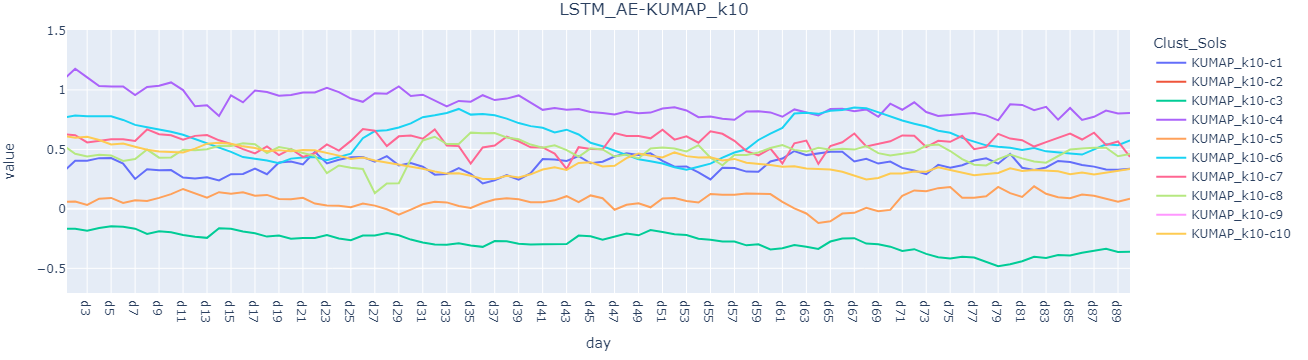

In [50]:
sol = 'KUMAP_k10'
sol_rows = []
for name in sol_names:
    n = name.split('-')[0]
    if n == sol:
        sol_rows.append(name)
        
df_centroids_melt = df_centroids[df_centroids['Clust_Sols'].isin(sol_rows)]
df_centroids_melt = pd.melt(df_centroids_melt, id_vars=['Clust_Sols'], value_vars=window_cols,
        var_name='day', value_name='value')

fig = px.line(df_centroids_melt, x="day", y="value", color='Clust_Sols')
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20),
                 title={'text':f'{Model_Name}-{sol}', 'xanchor':'center', 'x':0.5})
fig.show()

---
---
# Saving Outputs

---
## Clustering

### Solutions

In [72]:
df_sols.head()

,short_ID,window_ID,window_start_date,UMAP_V1,UMAP_V2,kMeans_k2,kMeans_k3,kMeans_k4,kMeans_k5,kMeans_k6,...,KUMAP_k16,KUMAP_k17,KUMAP_k18,KUMAP_k19,KUMAP_k20,KUMAP_k21,KUMAP_k22,KUMAP_k23,KUMAP_k24,KUMAP_k25
0,127,0,2018-01-20,14.730165,14.922711,1,3,1,4,6,...,3,4,13,14,6,13,9,7,11,18
1,127,1,2018-04-20,14.456367,15.064330,1,3,1,4,6,...,3,4,13,14,6,13,9,7,11,18
2,127,2,2018-07-19,14.490791,14.844275,1,3,1,4,6,...,16,13,3,3,3,8,17,12,18,12
3,127,3,2018-10-17,13.377369,15.922905,1,3,1,4,6,...,16,10,14,15,5,15,17,17,15,10
4,127,4,2019-01-15,14.862516,16.851736,1,3,1,4,6,...,16,10,14,15,5,15,17,17,15,10


In [ ]:
solution_fileName = solution_name.replace(":", "-" ).replace("-", "_" )
solution_fileName = f'{Model_Name}-{solution_fileName}.csv'

In [73]:
if on_gradient == False:
    os.makedirs(f'../ModelResults/Clustering/Solutions/{dataset_name}', exist_ok=True)  
    df_sols.to_csv(f'../ModelResults/Clustering/Solutions/{dataset_name}/{solution_fileName}', index=False)
else:
    gradient_fileName = f'Solutions-{solution_fileName}'    #df_centroids.to_csv(f'solution_fileName', index=False)
    df_sols.to_csv(gradient_fileName, index=False)    

### Centroids

In [80]:
df_centroids.head()

,Clust_Sols,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d81,d82,d83,d84,d85,d86,d87,d88,d89,d90
0,kMeans_k2-c1,0.334658,0.343587,0.322109,0.333589,0.312088,0.282053,0.235207,0.250145,0.240007,...,0.131280,0.135520,0.130736,0.134626,0.148448,0.140359,0.150217,0.148680,0.143069,0.154236
1,kMeans_k2-c2,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,...,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000
2,kMeans_k3-c1,-4.315424,-4.365424,-4.339589,-4.006331,-4.848047,-5.348009,-6.166704,-6.550000,-6.550000,...,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-6.550000,-6.100000
3,kMeans_k3-c2,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,...,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000
4,kMeans_k3-c3,0.438339,0.448582,0.426048,0.430355,0.427141,0.407584,0.377947,0.401765,0.391400,...,0.290283,0.294618,0.289727,0.293704,0.307834,0.299564,0.309642,0.308071,0.292301,0.293684


In [74]:
if on_gradient == False:
    os.makedirs(f'../ModelResults/Clustering/Centroids/{dataset_name}', exist_ok=True)  
    df_centroids.to_csv(f'../ModelResults/Clustering/Centroids/{dataset_name}/{solution_fileName}', index=False)
else:
    gradient_fileName = f'Centroids-{solution_fileName}'
    df_centroids.to_csv(gradient_fileName, index=False)    

---
## Auto-Encoder Recontruction

In [75]:
df_reconstruct.head()

,short_ID,window_ID,UMAP_V1,UMAP_V2,MSE,d1,d2,d3,d4,d5,...,d81,d82,d83,d84,d85,d86,d87,d88,d89,d90
0,127,0,14.730165,14.922711,0.036224,0.551866,0.511525,0.418921,0.393570,0.376943,...,0.918718,0.906462,0.890662,0.858993,0.806989,0.740205,0.668449,0.601423,0.551958,0.541089
1,127,1,14.456367,15.064330,0.001781,0.511137,0.535627,0.456171,0.430780,0.399154,...,1.020759,0.995790,0.969248,0.935301,0.888822,0.829687,0.764942,0.704779,0.660446,0.643842
2,127,2,14.490791,14.844275,0.008751,0.540324,0.648341,0.572467,0.494882,0.453017,...,0.935303,0.903605,0.875646,0.850747,0.823421,0.788953,0.749272,0.711617,0.685288,0.679950
3,127,3,13.377369,15.922905,0.003819,0.503273,0.541258,0.460892,0.437429,0.392647,...,0.443012,0.411199,0.390286,0.376721,0.359625,0.327530,0.277821,0.214182,0.147162,0.123559
4,127,4,14.862516,16.851736,0.057101,1.141542,0.830329,0.652757,0.551421,0.494866,...,0.576964,0.515441,0.453450,0.377552,0.284933,0.226393,0.501658,1.006430,0.971729,0.888564


### Reconstructed Data

In [76]:
df_reconstructed_data = pd.DataFrame()
df_reconstructed_data[['short_ID', 'window_ID']] = df_reconstruct[['short_ID', 'window_ID']]
df_reconstructed_data['window_start_date'] = Data['window_start_date']
df_reconstructed_data[window_cols] = df_reconstruct[window_cols]
df_reconstructed_data.head()

,short_ID,window_ID,window_start_date,d1,d2,d3,d4,d5,d6,d7,...,d81,d82,d83,d84,d85,d86,d87,d88,d89,d90
0,127,0,2018-01-20,0.551866,0.511525,0.418921,0.393570,0.376943,0.354484,0.342850,...,0.918718,0.906462,0.890662,0.858993,0.806989,0.740205,0.668449,0.601423,0.551958,0.541089
1,127,1,2018-04-20,0.511137,0.535627,0.456171,0.430780,0.399154,0.356051,0.327404,...,1.020759,0.995790,0.969248,0.935301,0.888822,0.829687,0.764942,0.704779,0.660446,0.643842
2,127,2,2018-07-19,0.540324,0.648341,0.572467,0.494882,0.453017,0.394184,0.348231,...,0.935303,0.903605,0.875646,0.850747,0.823421,0.788953,0.749272,0.711617,0.685288,0.679950
3,127,3,2018-10-17,0.503273,0.541258,0.460892,0.437429,0.392647,0.366842,0.359645,...,0.443012,0.411199,0.390286,0.376721,0.359625,0.327530,0.277821,0.214182,0.147162,0.123559
4,127,4,2019-01-15,1.141542,0.830329,0.652757,0.551421,0.494866,0.487153,0.502427,...,0.576964,0.515441,0.453450,0.377552,0.284933,0.226393,0.501658,1.006430,0.971729,0.888564


In [77]:
if on_gradient == False:
    os.makedirs(f'../ModelResults/AE_Reconstruction/Reconstructed_Data/{dataset_name}', exist_ok=True)  
    df_reconstructed_data.to_csv(f'../ModelResults/AE_Reconstruction/Reconstructed_Data/{dataset_name}/{solution_fileName}', index=False)  
else:
    gradient_fileName = f'Reconstructed_Data-{solution_fileName}'
    df_reconstructed_data.to_csv(gradient_fileName, index=False)        

### MSE

In [78]:
df_mse = pd.DataFrame()
df_mse[['short_ID', 'window_ID']] = df_reconstruct[['short_ID', 'window_ID']]
df_mse['MSE'] = df_reconstruct['MSE']
df_mse.head()

,short_ID,window_ID,MSE
0,127,0,0.036224
1,127,1,0.001781
2,127,2,0.008751
3,127,3,0.003819
4,127,4,0.057101


In [79]:
if on_gradient == False:
    os.makedirs(f'../ModelResults/AE_Reconstruction/MSE/{dataset_name}', exist_ok=True)  
    df_mse.to_csv(f'../ModelResults/AE_Reconstruction/MSE/{dataset_name}/{solution_fileName}', index=False)  
else:
    gradient_fileName = f'MSE-{solution_fileName}'
    df_mse.to_csv(gradient_fileName, index=False)        